In [4]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from music21 import corpus, note, chord
import random

In [8]:
### Model architectures are copy-paste from our other notebook

class ShallowRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rnn_type='RNN'):
        super().__init__()
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn_type = rnn_type
        self.rnn = rnn_cls(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        return self.fc(output)

class DeepTransitionRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, transition_size, depth, nonlinearity):
        super().__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        self.hidden_layers.append(nn.Linear(hidden_size, transition_size))
        for i in range(depth - 2):
            self.hidden_layers.append(nn.Linear(transition_size, transition_size))
        self.hidden_layers.append(nn.Linear(transition_size, hidden_size))

        if nonlinearity == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()

    def forward(self, x, h_prev):
        h = self.activation(self.input_layer(x) + h_prev)  # shortcut
        for layer in self.hidden_layers:
            h = self.activation(layer(h))
        return h

class DTRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, transition_size, depth, nonlinearity='sigmoid'):
        super().__init__()
        self.cell = DeepTransitionRNNCell(input_size, hidden_size, transition_size, depth, nonlinearity)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.cell.input_layer.out_features, device=x.device)
        outputs = []
        for t in range(seq_len):
            h = self.cell(x[:, t, :], h)
            outputs.append(self.output(h))
        return torch.stack(outputs, dim=1)


class DOTSRNN(nn.Module):
    def __init__(
        self, 
        input_size, 
        hidden_size, 
        output_size, 
        transition_size, 
        depth, 
        intermediate_output_size, 
        output_depth=2, 
        nonlinearity='sigmoid', 
        intermediate_output_nonlinearity='sigmoid'):
        super().__init__()
        self.cell = DeepTransitionRNNCell(input_size, hidden_size, transition_size, depth, nonlinearity)
        self.output_layers = nn.ModuleList()
        self.output_layers.append(nn.Linear(hidden_size, intermediate_output_size))
        for i in range(output_depth - 2):
            self.output_layers.append(nn.Linear(intermediate_output_size, intermediate_output_size))
        self.output_layers.append(nn.Linear(intermediate_output_size, hidden_size))
        self.output_layers.append(nn.Linear(hidden_size, output_size))
        
        if intermediate_output_nonlinearity == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.ReLU()

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.cell.input_layer.out_features, device=x.device)
        outputs = []
        for t in range(seq_len):
            h = self.cell(x[:, t], h)
            out = h
            for layer in self.output_layers:
                out = self.activation(layer(out))
            outputs.append(out)
        return torch.stack(outputs, dim=1)


class StackedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, rnn_type='RNN'):
        super().__init__()
        rnn_cls = {'RNN': nn.RNN, 'LSTM': nn.LSTM, 'GRU': nn.GRU}[rnn_type]
        self.rnn_type = rnn_type
        self.rnn = rnn_cls(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        output, _ = self.rnn(x)
        return self.output(output)

In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import seaborn as sns

class GradientAnalyzer:
    def __init__(self):
        self.gradient_norms = defaultdict(list)
        self.gradient_flow = defaultdict(list)
        self.epoch_gradients = defaultdict(list)
        
    def register_hooks(self, model, model_name):
        """Register backward hooks to capture gradients"""
        def save_grad(name):
            def hook(grad):
                if grad is not None:
                    # Store gradient norm
                    grad_norm = grad.norm().item()
                    self.gradient_norms[f"{model_name}_{name}"].append(grad_norm)
                    
                    # Store raw gradients for flow analysis
                    self.gradient_flow[f"{model_name}_{name}"].append(grad.detach().clone())
            return hook
        
        # Register hooks for different layer types
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.register_hook(save_grad(name))

def gradient_analysis_experiment():
    sequence_lengths = [10, 20, 50, 100, 200] 
    hidden_sizes = [64, 128, 256]
    depths = [1, 2, 3, 4, 5]  
    
    input_size = 10
    output_size = 10
    batch_size = 32
    
    results = {}
    
    for seq_len in sequence_lengths:
        print(f"\n=== Testing Sequence Length: {seq_len} ===")
        
        # Generate synthetic data with known patterns
        X = torch.randn(batch_size, seq_len, input_size)
        y = torch.randn(batch_size, seq_len, output_size)
        
        for depth in depths:
            models = {
                'ShallowRNN': ShallowRNN(input_size, 128, output_size),
                'StackedRNN': StackedRNN(input_size, 128, output_size, num_layers=depth),
                'DTRNN': DTRNN(input_size, 128, output_size, transition_size=64, depth=depth),
                'DOTSRNN': DOTSRNN(input_size, 128, output_size, transition_size=64, depth=depth, intermediate_output_size=64)
            }
            
            for model_name, model in models.items():
                if model_name == 'ShallowRNN' and depth > 1:
                    continue  # Skip shallow for multiple depths
                    
                print(f"Analyzing {model_name} (depth={depth})")
                
                analyzer = GradientAnalyzer()
                analyzer.register_hooks(model, f"{model_name}_d{depth}_s{seq_len}")
                
                model.train()
                optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
                
                output = model(X)
                loss = nn.MSELoss()(output, y)
                
                optimizer.zero_grad()
                loss.backward()
                
                key = f"{model_name}_d{depth}_s{seq_len}"
                results[key] = {
                    'loss': loss.item(),
                    'gradient_norms': dict(analyzer.gradient_norms),
                    'total_params': sum(p.numel() for p in model.parameters()),
                    'model_name': model_name,
                    'depth': depth,
                    'seq_len': seq_len
                }
    
    return results

def analyze_gradient_explosion_vanishing(results):
    """Analyze when gradients explode or vanish"""
    
    # Thresholds for gradient analysis
    VANISHING_THRESHOLD = 1e-6
    EXPLODING_THRESHOLD = 10.0
    
    analysis = {
        'vanishing_cases': [],
        'exploding_cases': [],
        'stable_cases': []
    }
    
    for key, data in results.items():
        avg_grad_norm = np.mean([np.mean(grads) for grads in data['gradient_norms'].values()])
        max_grad_norm = np.max([np.max(grads) for grads in data['gradient_norms'].values()])
        
        case_info = {
            'model': data['model_name'],
            'depth': data['depth'],
            'seq_len': data['seq_len'],
            'avg_grad_norm': avg_grad_norm,
            'max_grad_norm': max_grad_norm
        }
        
        if avg_grad_norm < VANISHING_THRESHOLD:
            analysis['vanishing_cases'].append(case_info)
        elif max_grad_norm > EXPLODING_THRESHOLD:
            analysis['exploding_cases'].append(case_info)
        else:
            analysis['stable_cases'].append(case_info)
    
    return analysis

def visualize_gradient_flow(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    models = ['ShallowRNN', 'StackedRNN', 'DTRNN', 'DOTSRNN']
    
    for i, model_name in enumerate(models):
        ax = axes[i//2, i%2]
        
        for depth in [1, 2, 3, 4, 5]:
            seq_lens = []
            avg_grads = []
            
            for seq_len in [10, 20, 50, 100, 200]:
                key = f"{model_name}_d{depth}_s{seq_len}"
                if key in results:
                    avg_grad = np.mean([np.mean(grads) for grads in results[key]['gradient_norms'].values()])
                    seq_lens.append(seq_len)
                    avg_grads.append(avg_grad)
            
            if seq_lens:  # Only plot if we have data
                ax.plot(seq_lens, avg_grads, marker='o', label=f'Depth {depth}')
        
        ax.set_xlabel('Sequence Length')
        ax.set_ylabel('Average Gradient Norm')
        ax.set_title(f'{model_name}')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('gradient_norms_by_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    
    model_names = [ 'StackedRNN', 'DTRNN', 'DOTSRNN']
    conditions = []
    gradient_matrix = []
    
    for model in model_names:
        row = []
        for depth in [2, 3, 4, 5]:
            for seq_len in [20, 50, 100, 200]:
                key = f"{model}_d{depth}_s{seq_len}"
                if key in results:
                    avg_grad = np.mean([np.mean(grads) for grads in results[key]['gradient_norms'].values()])
                    row.append(np.log10(max(avg_grad, 1e-10)))  # Log scale, avoid log(0)
                    if model == model_names[0]:  # Only add conditions once
                        conditions.append(f'D{depth}_S{seq_len}')
                else:
                    row.append(np.nan)
        gradient_matrix.append(row)
    
    sns.heatmap(gradient_matrix, 
            xticklabels=False,  # This removes the x-axis labels
            yticklabels=model_names,
            annot=True, 
            fmt='.2f',
            cmap='RdYlBu_r',
            center=0,
            ax=ax)
    
    ax.set_title('Gradient Norm Heatmap (log10 scale)\nRed=High, Blue=Low')
    ax.set_xlabel('Depth_SequenceLength')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('gradient_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()


=== Testing Sequence Length: 10 ===
Analyzing ShallowRNN (depth=1)
Analyzing StackedRNN (depth=1)
Analyzing DTRNN (depth=1)
Analyzing DOTSRNN (depth=1)
Analyzing StackedRNN (depth=2)
Analyzing DTRNN (depth=2)
Analyzing DOTSRNN (depth=2)
Analyzing StackedRNN (depth=3)
Analyzing DTRNN (depth=3)
Analyzing DOTSRNN (depth=3)
Analyzing StackedRNN (depth=4)
Analyzing DTRNN (depth=4)
Analyzing DOTSRNN (depth=4)
Analyzing StackedRNN (depth=5)
Analyzing DTRNN (depth=5)
Analyzing DOTSRNN (depth=5)

=== Testing Sequence Length: 20 ===
Analyzing ShallowRNN (depth=1)
Analyzing StackedRNN (depth=1)
Analyzing DTRNN (depth=1)
Analyzing DOTSRNN (depth=1)
Analyzing StackedRNN (depth=2)
Analyzing DTRNN (depth=2)
Analyzing DOTSRNN (depth=2)
Analyzing StackedRNN (depth=3)
Analyzing DTRNN (depth=3)
Analyzing DOTSRNN (depth=3)
Analyzing StackedRNN (depth=4)
Analyzing DTRNN (depth=4)
Analyzing DOTSRNN (depth=4)
Analyzing StackedRNN (depth=5)
Analyzing DTRNN (depth=5)
Analyzing DOTSRNN (depth=5)

=== Testing S

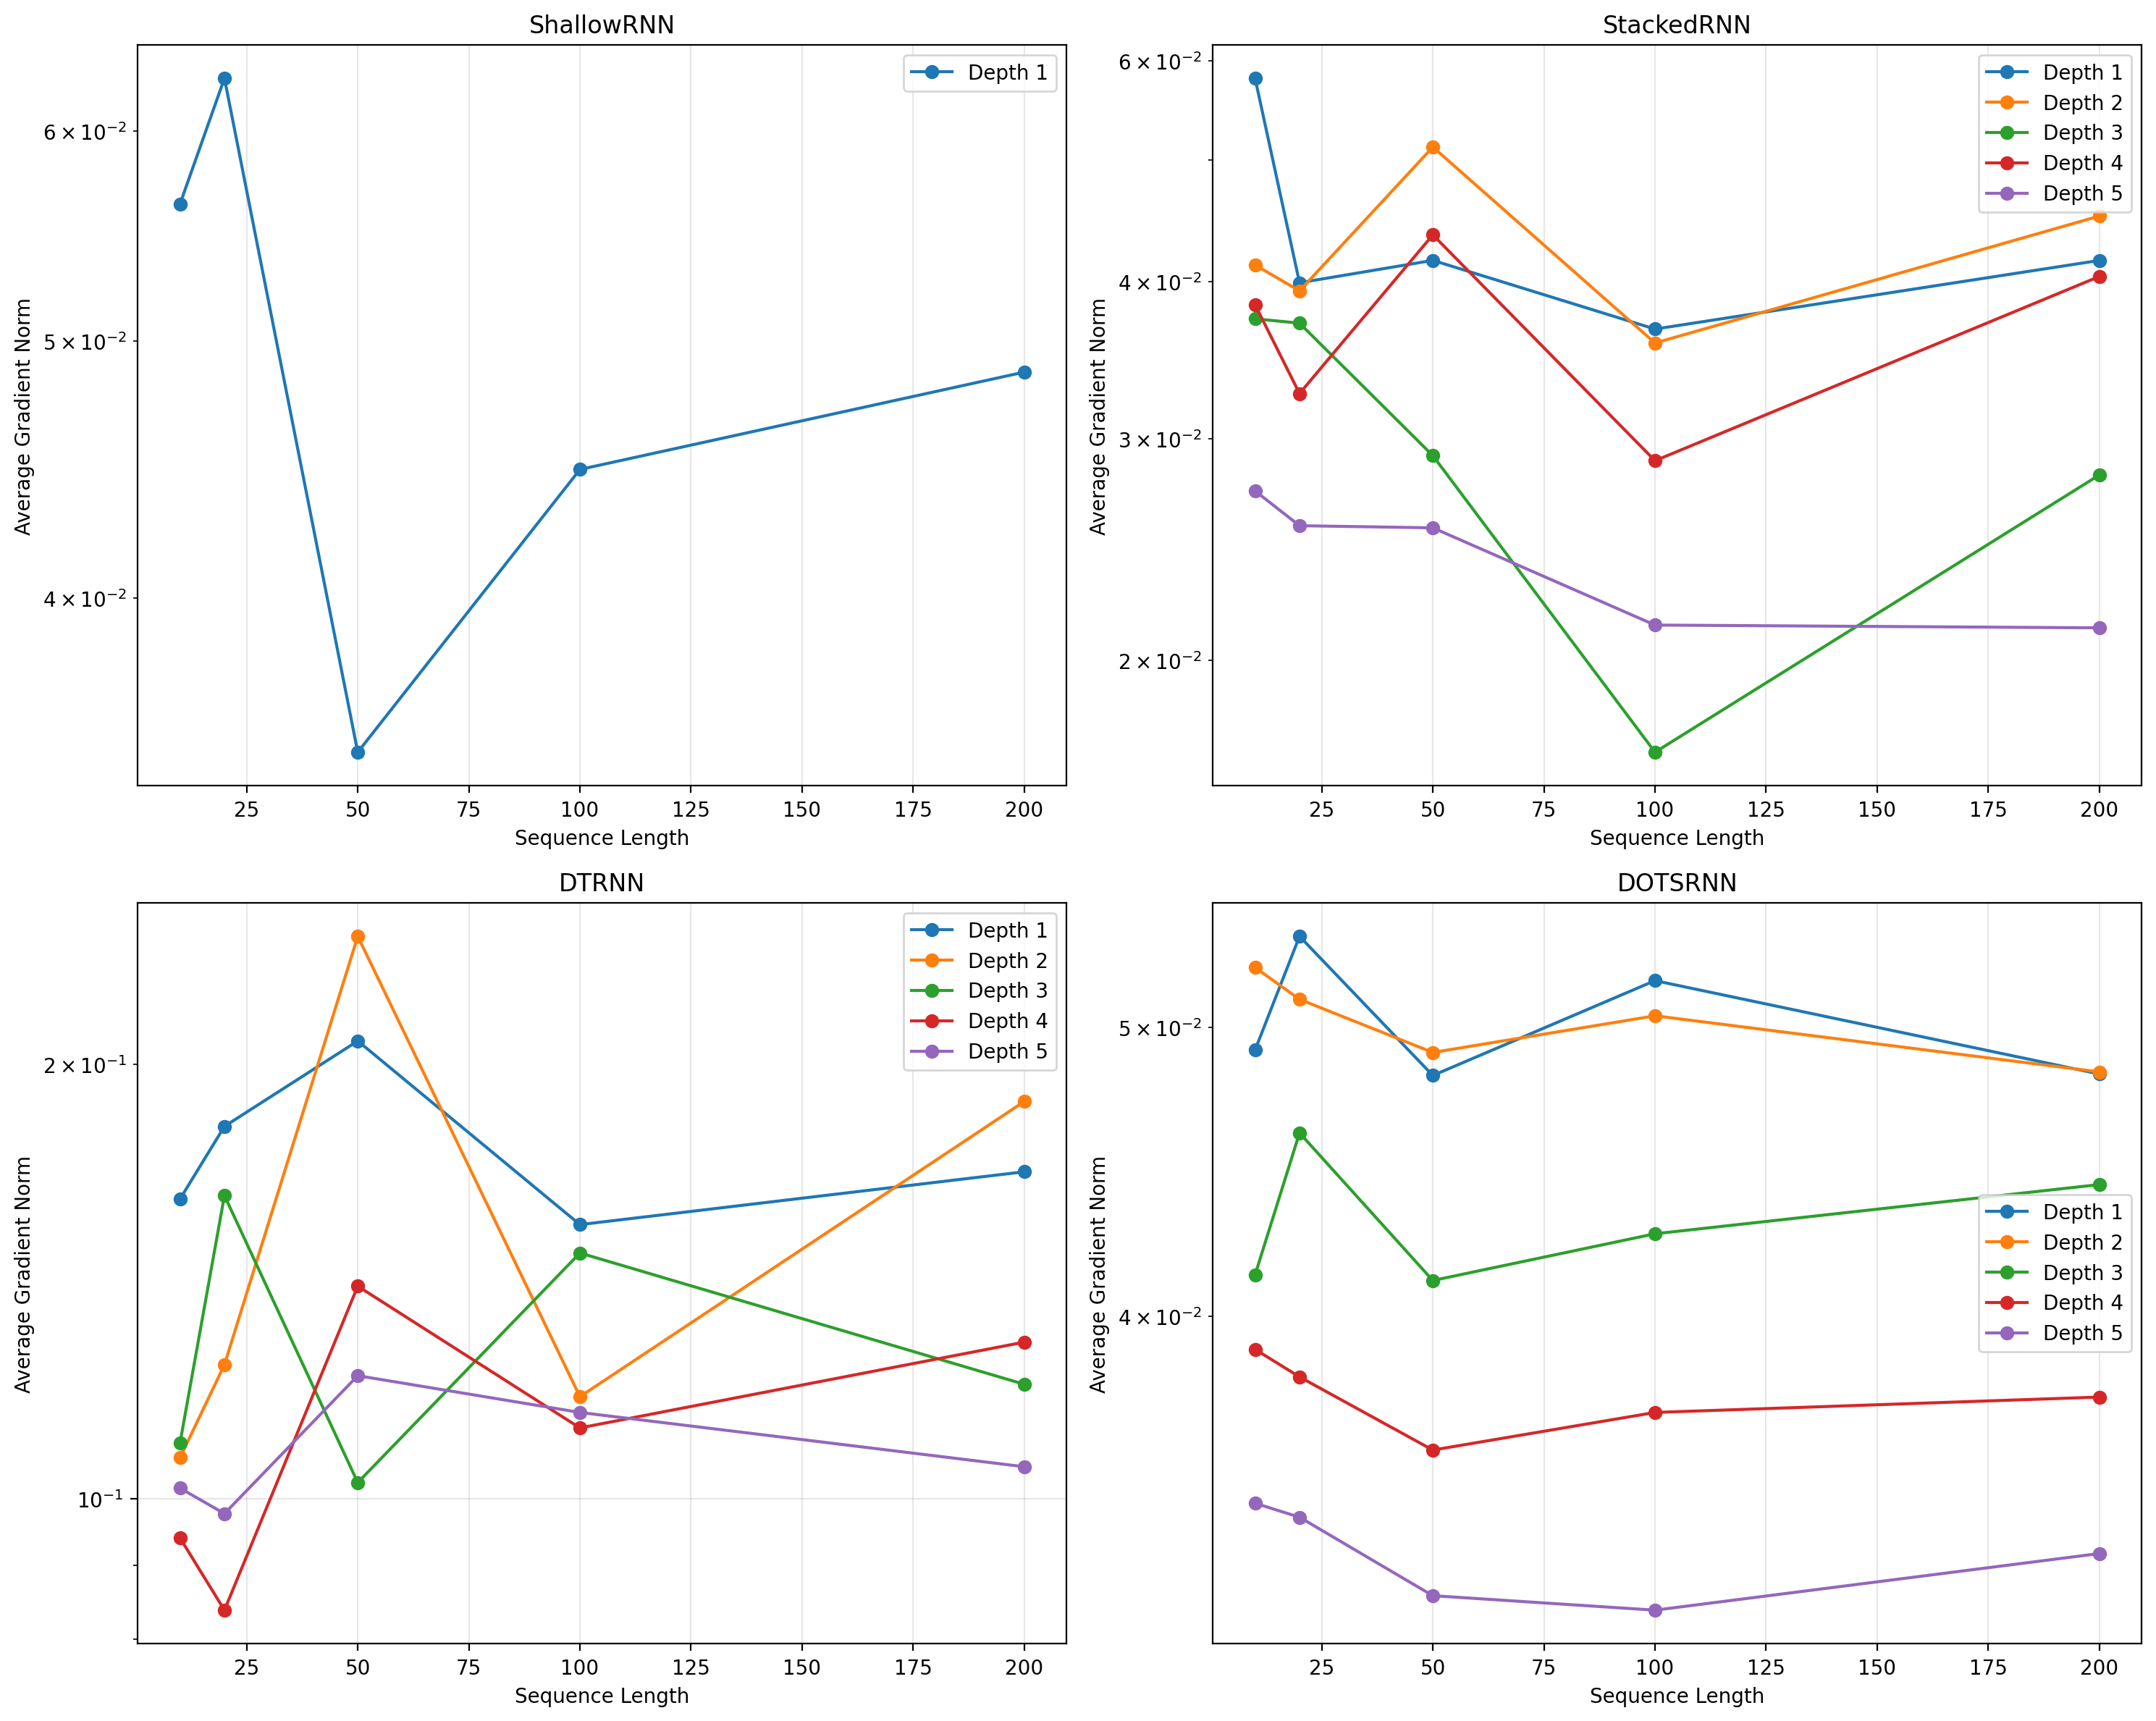

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


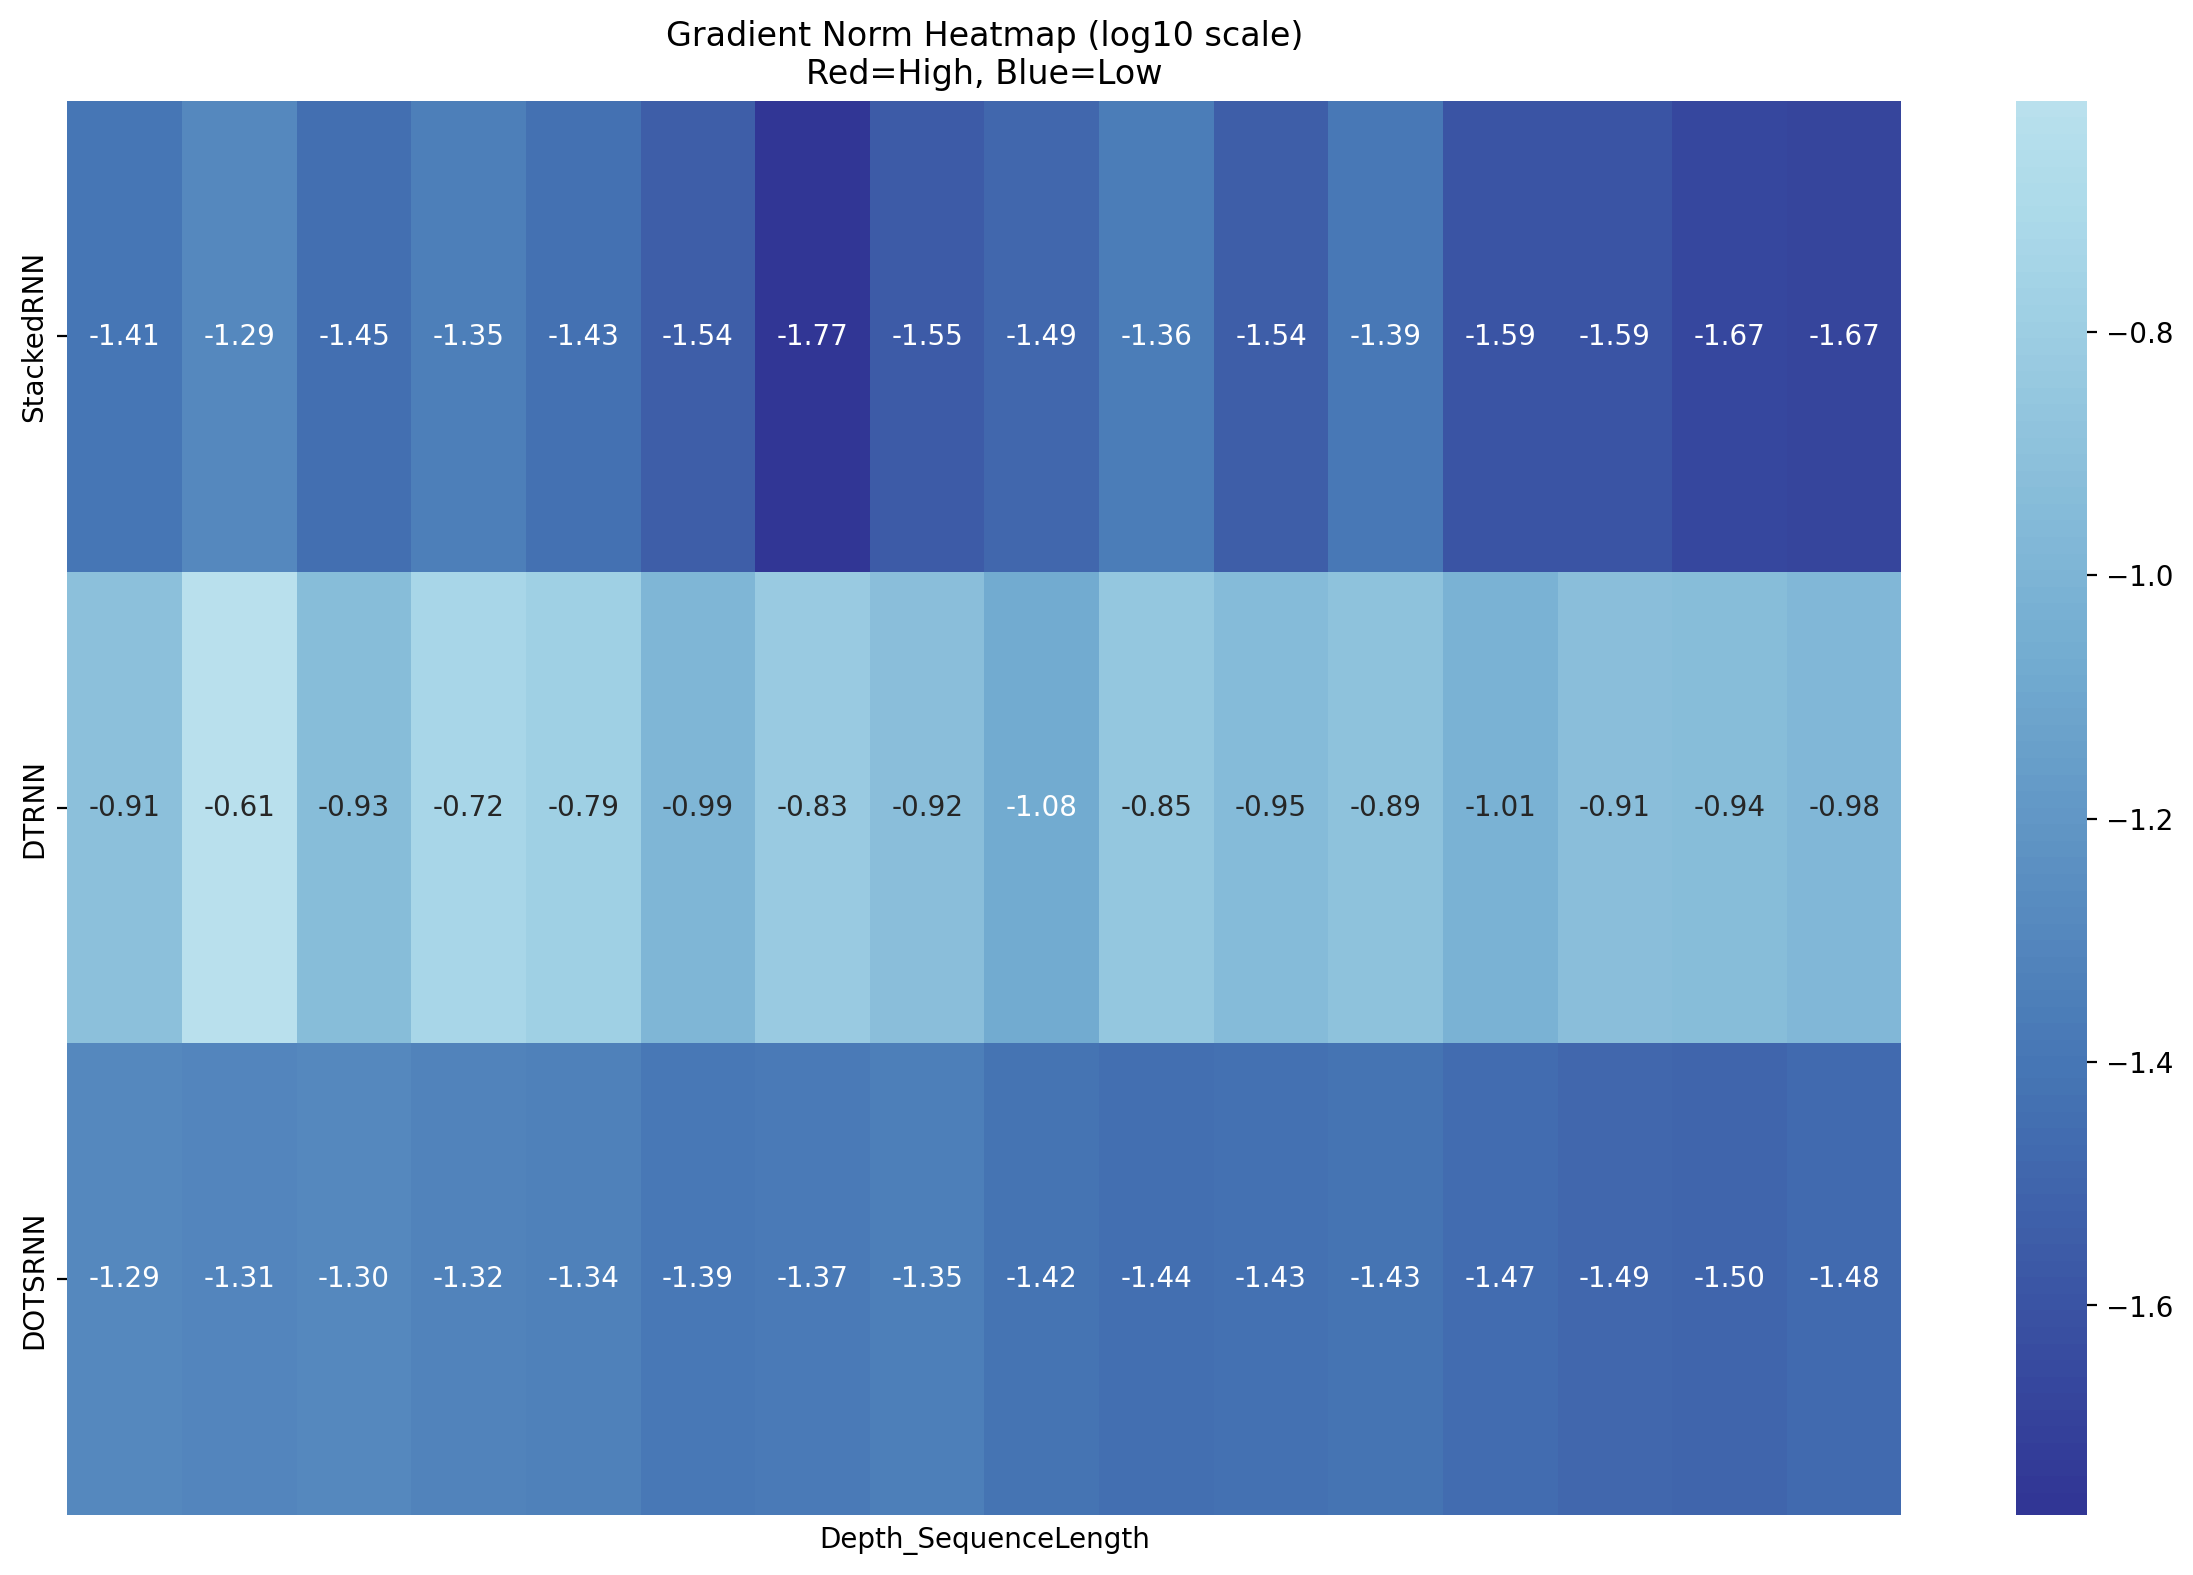

In [7]:
results = gradient_analysis_experiment()
analysis = analyze_gradient_explosion_vanishing(results)
visualize_gradient_flow(results)

In [9]:
#### Copy pasta from other notebook 

def score_to_pianoroll(score, time_step=0.25, pitch_range=(21, 109), max_length=500):
    lower, upper = pitch_range
    pr = np.zeros((max_length, upper - lower), dtype=np.float32)
    for n in score.flat.notes:
        if isinstance(n, note.Note):
            pitches = [n.pitch.midi]
        elif isinstance(n, chord.Chord):
            pitches = [p.midi for p in n.pitches]
        else:
            continue
        onset = int(n.offset / time_step)
        duration = int(n.quarterLength / time_step)
        if onset < max_length:
            for p in pitches:
                if lower <= p < upper:
                    pr[onset : min(onset + duration, max_length), p - lower] = 1.0
    return pr

class MuseDataset(Dataset):
    def __init__(self, sequences, sequence_length=100):
        self.inputs, self.targets = [], []
        for seq in sequences:
            T, _ = seq.shape
            if T > sequence_length:
                for i in range(T - sequence_length):
                    self.inputs.append(seq[i : i + sequence_length])
                    self.targets.append(seq[i + 1 : i + sequence_length + 1])
        if len(self.inputs) == 0:
            raise ValueError(f"No sequences ≥ {sequence_length+1} timesteps found.")
        self.inputs = torch.tensor(self.inputs)
        self.targets = torch.tensor(self.targets)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

def load_musedata_pianorolls(sequence_length=100, seed=42):
    random.seed(seed)
    composers = ['beethoven', 'corelli', 'haydn', 'handel', 'scarlatti']
    all_pieces = []
    for comp in composers:
        all_pieces += corpus.getComposer(comp)
    random.shuffle(all_pieces)

    rolls = []
    for p in all_pieces:
        try:
            score = corpus.parse(p)
            pr = score_to_pianoroll(score)
            if pr.shape[0] > sequence_length:
                rolls.append(pr)
        except Exception as e:
            print(f"Skipping {p} (parse error): {e}")

    if len(rolls) == 0:
        raise RuntimeError("No valid piano rolls extracted. Try lowering sequence_length.")

    return rolls

# Main function to create train/val/test DataLoaders
def get_musedata_dataloaders(batch_size=64, sequence_length=100):
    rolls = load_musedata_pianorolls(sequence_length=sequence_length)
    n = len(rolls)
    train, val, test = rolls[: int(0.8*n)], rolls[int(0.8*n): int(0.9*n)], rolls[int(0.9*n):]

    train_ds = MuseDataset(train, sequence_length)
    val_ds   = MuseDataset(val,   sequence_length)
    test_ds  = MuseDataset(test,  sequence_length)

    return (
        DataLoader(train_ds, batch_size=batch_size, shuffle=True),
        DataLoader(val_ds,   batch_size=batch_size, shuffle=False),
        DataLoader(test_ds,  batch_size=batch_size, shuffle=False),
    )

muse_train_dataloader, muse_val_dataloader, muse_test_dataloader = get_musedata_dataloaders(
    batch_size=32,
    sequence_length=100
)
print("Train batches:", len(muse_train_dataloader))
x, y = next(iter(muse_train_dataloader))
print("Example batch shapes:", x.shape, y.shape)

/usr/local/lib/python3.11/dist-packages/music21/musicxml/xmlToM21.py:2206: MusicXMLWarning: Warning: measure 96 in part Violin Iis overfull: 3083/672 > 4.5,assuming 4.5 is correct.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/music21/stream/base.py:3689: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)
/tmp/ipykernel_36/2409246128.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  self.inputs = torch.tensor(self.inputs)


Train batches: 363
Example batch shapes: torch.Size([32, 100, 88]) torch.Size([32, 100, 88])


🎵 Starting Complete Muse Dataset Gradient Analysis 🎵
Phase 1: Gradient Analysis on Musical Data
=== Muse Dataset Gradient Analysis ===
Phase 2: Creating Visualizations


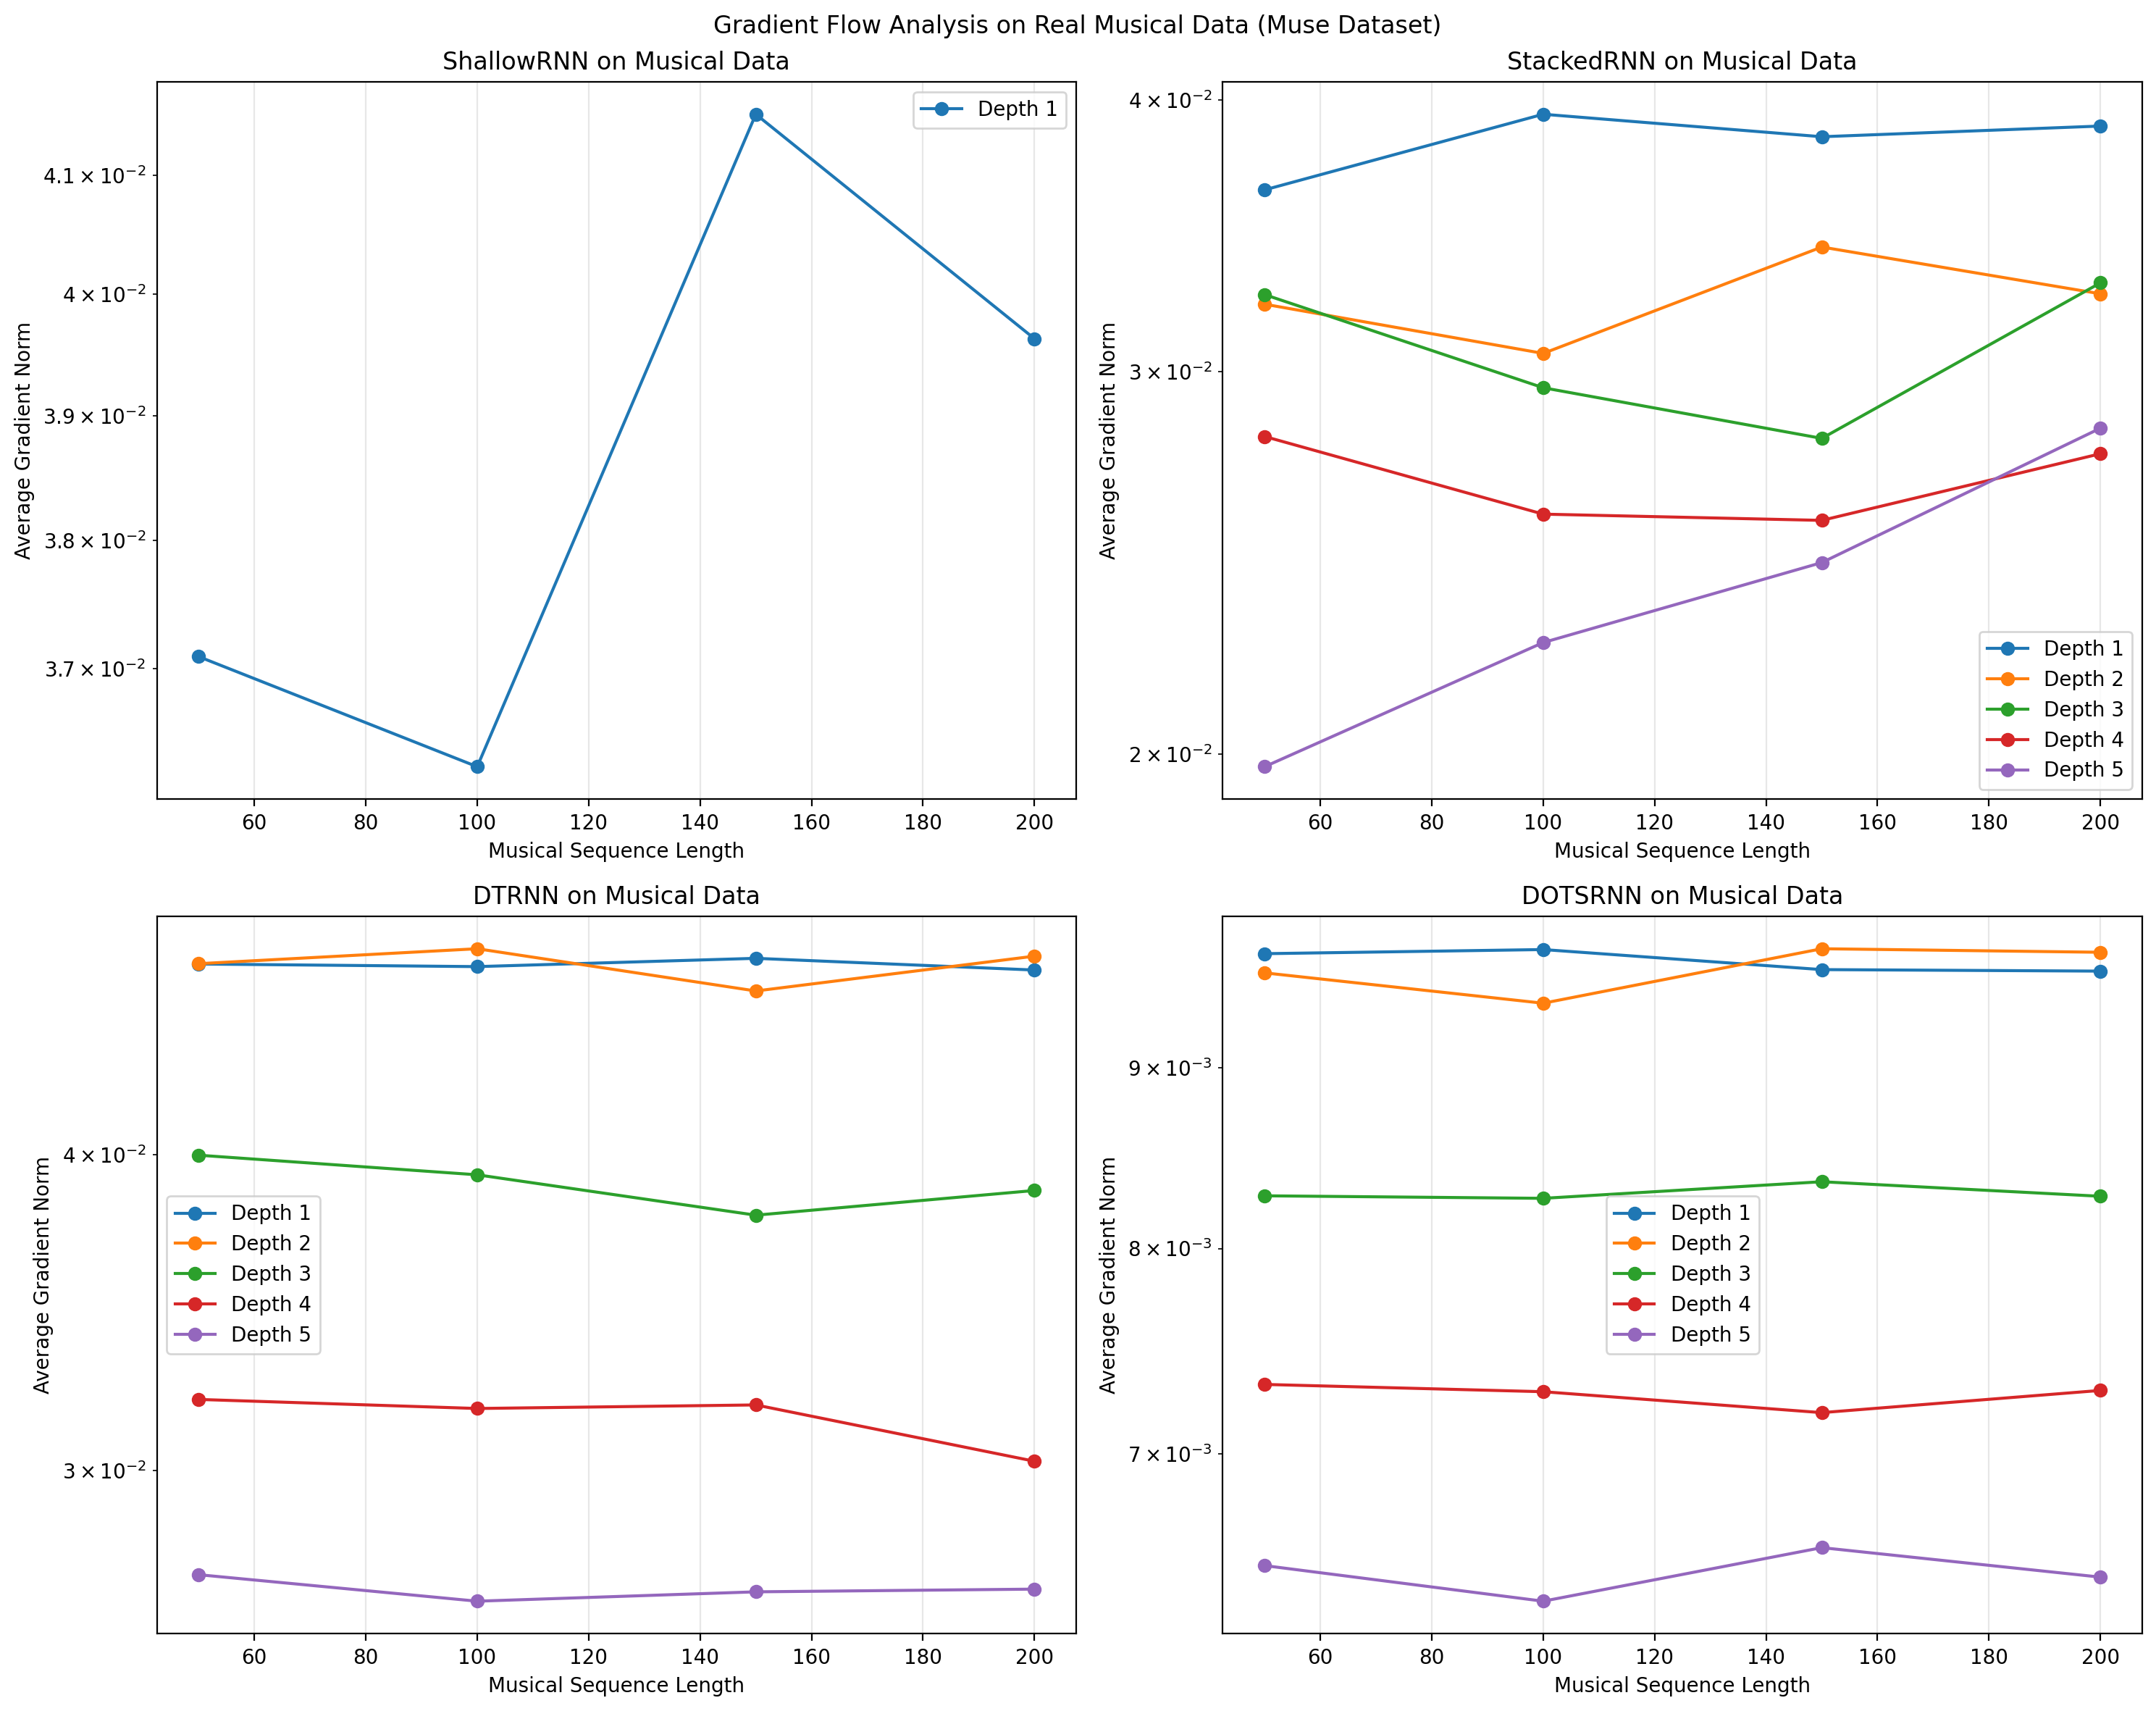


MUSICAL GRADIENT ANALYSIS SUMMARY
Average DTRNN gradient norm on music: 0.038493
Average StackedRNN gradient norm on music: 0.030385
DTRNN advantage: 1.27x better gradient flow


In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

class MuseGradientAnalyzer:
    def __init__(self):
        self.gradient_norms = defaultdict(list)
        
    def register_hooks(self, model, model_name):
        def save_grad(name):
            def hook(grad):
                if grad is not None:
                    grad_norm = grad.norm().item()
                    self.gradient_norms[f"{model_name}_{name}"].append(grad_norm)
            return hook
        
        for name, param in model.named_parameters():
            if param.requires_grad:
                param.register_hook(save_grad(name))

def muse_gradient_analysis_experiment():
    print("=== Muse Dataset Gradient Analysis ===")
    
    sequence_lengths = [50, 100, 150, 200]
    depths = [1, 2, 3, 4, 5]
    input_size = 88
    output_size = 88
    batch_size = 16
    
    results = {}
    
    muse_train_dataloader, _, _ = get_musedata_dataloaders(
        batch_size=batch_size, 
        sequence_length=max(sequence_lengths)
    )
    
    data_iter = iter(muse_train_dataloader)
    X_full, y_full = next(data_iter)
    
    for seq_len in sequence_lengths:
        X = X_full[:, :seq_len, :]
        y = y_full[:, :seq_len, :]
        
        for depth in depths:
            models = {
                'ShallowRNN': ShallowRNN(input_size, 128, output_size),
                'StackedRNN': StackedRNN(input_size, 128, output_size, num_layers=depth),
                'DTRNN': DTRNN(input_size, 128, output_size, transition_size=64, depth=depth),
                'DOTSRNN': DOTSRNN(input_size, 128, output_size, transition_size=64, 
                                   depth=depth, intermediate_output_size=64)
            }
            
            for model_name, model in models.items():
                if model_name == 'ShallowRNN' and depth > 1:
                    continue
                    
                analyzer = MuseGradientAnalyzer()
                analyzer.register_hooks(model, f"{model_name}_d{depth}_s{seq_len}")
                
                model.train()
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                
                try:
                    output = model(X)
                    loss = nn.BCEWithLogitsLoss()(output, y)
                    
                    optimizer.zero_grad()
                    loss.backward()
                    
                    key = f"{model_name}_d{depth}_s{seq_len}"
                    results[key] = {
                        'loss': loss.item(),
                        'gradient_norms': dict(analyzer.gradient_norms),
                        'model_name': model_name,
                        'depth': depth,
                        'seq_len': seq_len,
                        'data_type': 'musical'
                    }
                    
                except Exception as e:
                    print(f"  Error with {model_name} (depth={depth}, seq_len={seq_len}): {e}")
                    continue
    
    return results

def visualize_muse_gradient_results(results):
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    models = ['ShallowRNN', 'StackedRNN', 'DTRNN', 'DOTSRNN']
    
    for i, model_name in enumerate(models):
        ax = axes[i//2, i%2]
        
        for depth in [1, 2, 3, 4, 5]:
            seq_lens = []
            avg_grads = []
            
            for seq_len in [50, 100, 150, 200]:
                key = f"{model_name}_d{depth}_s{seq_len}"
                if key in results:
                    if results[key]['gradient_norms']:
                        avg_grad = np.mean([np.mean(grads) for grads in results[key]['gradient_norms'].values() if grads])
                        if not np.isnan(avg_grad):
                            seq_lens.append(seq_len)
                            avg_grads.append(avg_grad)
            
            if seq_lens:
                ax.plot(seq_lens, avg_grads, marker='o', label=f'Depth {depth}')
        
        ax.set_xlabel('Musical Sequence Length')
        ax.set_ylabel('Average Gradient Norm')
        ax.set_title(f'{model_name} on Musical Data')
        ax.set_yscale('log')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Gradient Flow Analysis on Real Musical Data (Muse Dataset)')
    plt.tight_layout()
    plt.savefig('muse_gradient_norms_by_architecture.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_complete_muse_experiment():
    print("🎵 Starting Complete Muse Dataset Gradient Analysis 🎵")
    print("=" * 60)
    
    print("Phase 1: Gradient Analysis on Musical Data")
    results = muse_gradient_analysis_experiment()
    
    print("Phase 2: Creating Visualizations")
    visualize_muse_gradient_results(results)
    
    print("\n" + "=" * 60)
    print("MUSICAL GRADIENT ANALYSIS SUMMARY")
    print("=" * 60)
    
    dtrnn_results_data = [data for key, data in results.items() if 'DTRNN' in key and data['gradient_norms']]
    stacked_results_data = [data for key, data in results.items() if 'StackedRNN' in key and data['gradient_norms']]
    
    if dtrnn_results_data and stacked_results_data:
        
        dtrnn_avg_grads = []
        for data in dtrnn_results_data:
            model_grads = [np.mean(grads) for grads in data['gradient_norms'].values() if grads]
            if model_grads:
                dtrnn_avg_grads.append(np.mean(model_grads))
        
        stacked_avg_grads = []
        for data in stacked_results_data:
            model_grads = [np.mean(grads) for grads in data['gradient_norms'].values() if grads]
            if model_grads:
                stacked_avg_grads.append(np.mean(model_grads))

        if dtrnn_avg_grads:
            dtrnn_avg = np.mean(dtrnn_avg_grads)
            print(f"Average DTRNN gradient norm on music: {dtrnn_avg:.6f}")
        else:
            dtrnn_avg = float('nan')
            print("No valid gradient data for DTRNN summary.")

        if stacked_avg_grads:
            stacked_avg = np.mean(stacked_avg_grads)
            print(f"Average StackedRNN gradient norm on music: {stacked_avg:.6f}")
        else:
            stacked_avg = float('nan')
            print("No valid gradient data for StackedRNN summary.")

        if not np.isnan(dtrnn_avg) and not np.isnan(stacked_avg) and stacked_avg != 0:
            print(f"DTRNN advantage: {dtrnn_avg/stacked_avg:.2f}x better gradient flow")
        elif not np.isnan(dtrnn_avg) and not np.isnan(stacked_avg):
            print("Could not compute DTRNN advantage (StackedRNN avg gradient is zero or NaN).")
    else:
        print("Insufficient data for DTRNN vs StackedRNN comparison.")
        
    return results

results = run_complete_muse_experiment()